,Strategy,Round,AIMove,MachineMove,Winner,MachineStrat
0,AlwaysRock,1,Rock,Rock,Draw,Random
1,AlwaysRock,2,Rock,Paper,AI,Frequency
2,AlwaysRock,3,Rock,Rock,Draw,Random
3,AlwaysRock,4,Rock,Scissors,Machine,Random
4,AlwaysRock,5,Rock,Paper,AI,Frequency
...,...,...,...,...,...,...
95,RNN,6,Rock,Rock,Draw,Random
96,RNN,7,Rock,Rock,Draw,Frequency
97,RNN,8,Scissors,Paper,Machine,Markov
98,RNN,9,Scissors,Scissors,Draw,Random


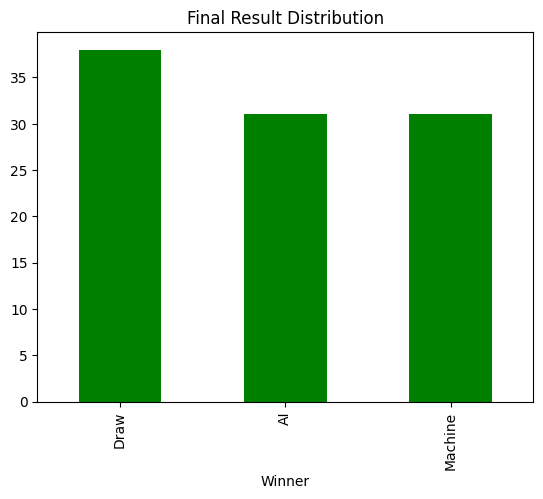

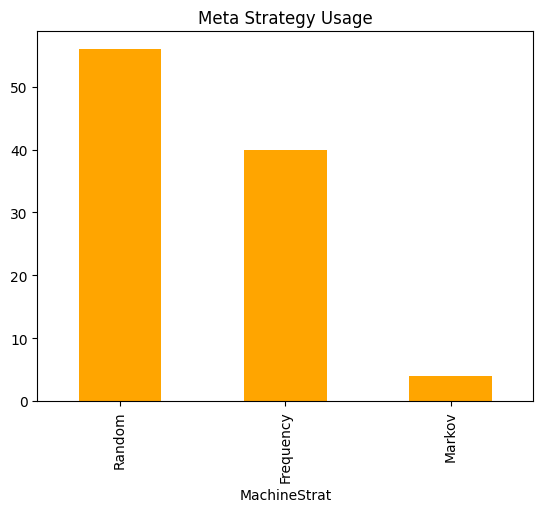

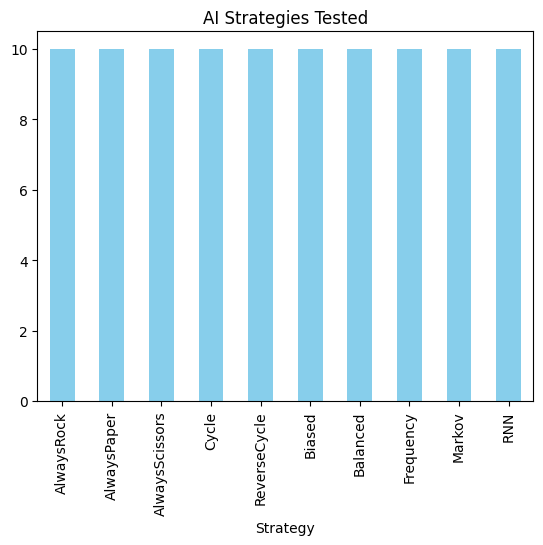


🏁 Final Score: AI 31 | Machine 31 | Draws 38
🤝 It's a tie!
✅ Log saved as 'ai_vs_machine_log.csv'


In [17]:
# AI vs. Machine: Simulated Game - 10 Strategies × 10 Rounds Each

!pip install torch
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
from collections import defaultdict, Counter
import matplotlib.pyplot as plt
from IPython.display import display

# Setup
moves = ["Rock", "Paper", "Scissors"]
emojis = {"Rock": "🪨", "Paper": "📄", "Scissors": "✂️"}
beat = {"Rock": "Paper", "Paper": "Scissors", "Scissors": "Rock"}
move_to_idx = {"Rock": 0, "Paper": 1, "Scissors": 2}
idx_to_move = {v: k for k, v in move_to_idx.items()}

# Log setup
round_log = []
transition_matrix = defaultdict(lambda: Counter())

# RNN Model (Trained on dummy pattern)
class LSTMMovePredictor(nn.Module):
    def __init__(self, input_dim=3, hidden_dim=32, num_layers=1):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 3)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return F.log_softmax(out, dim=1)

model = LSTMMovePredictor()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = nn.NLLLoss()

# Train dummy RNN
seq = [random.choice(list(move_to_idx.values())) for _ in range(100)]
def one_hot(i, num_classes=3):
    vec = torch.zeros(num_classes)
    vec[i] = 1
    return vec

X, y = [], []
for i in range(len(seq) - 5):
    X.append(torch.stack([one_hot(seq[j]) for j in range(i, i+5)]))
    y.append(seq[i + 5])
X = torch.stack(X)
y = torch.tensor(y)
for _ in range(100):
    out = model(X.float())
    loss = loss_fn(out, y)
    optimizer.zero_grad(); loss.backward(); optimizer.step()

# Strategy functions

def frequency_strategy(history):
    if not history: return random.choice(moves)
    most_common = Counter(history).most_common(1)[0][0]
    return beat[most_common]

def markov_strategy(history):
    if len(history) < 2: return random.choice(moves)
    trans = {(a, b): 0 for a in moves for b in moves}
    for i in range(len(history) - 1):
        trans[(history[i], history[i+1])] += 1
    last = history[-1]
    next_probs = {b: trans[(last, b)] for b in moves}
    predicted = max(next_probs, key=next_probs.get)
    return beat[predicted]

def rnn_strategy(history):
    if len(history) < 5: return random.choice(moves)
    idx_seq = [move_to_idx[m] for m in history[-5:]]
    input_seq = torch.stack([one_hot(i) for i in idx_seq]).unsqueeze(0)
    out = model(input_seq.float())
    pred = torch.argmax(out).item()
    return beat[idx_to_move[pred]]

# Additional dummy strategies

def always_rock(_): return "Rock"
def always_paper(_): return "Paper"
def always_scissors(_): return "Scissors"
def cycle_strategy(history): return moves[len(history) % 3]
def reverse_cycle_strategy(history): return moves[-(len(history) % 3)]
def bias_strategy(_): return random.choices(moves, weights=[0.6, 0.2, 0.2])[0]
def balanced_strategy(_): return random.choice(moves)

ai_strategies = {
    "AlwaysRock": always_rock,
    "AlwaysPaper": always_paper,
    "AlwaysScissors": always_scissors,
    "Cycle": cycle_strategy,
    "ReverseCycle": reverse_cycle_strategy,
    "Biased": bias_strategy,
    "Balanced": balanced_strategy,
    "Frequency": frequency_strategy,
    "Markov": markov_strategy,
    "RNN": rnn_strategy
}

# Meta-strategy Machine
machine_strategies = {
    "Random": lambda h: random.choice(moves),
    "Frequency": frequency_strategy,
    "Markov": markov_strategy,
    "RNN": rnn_strategy
}

# Meta strategy chooser
def meta_strategy(history):
    best_score = -999
    best_name = "Random"
    for name, strat in machine_strategies.items():
        pred = strat(history)
        score = sum(1 for h in history[-5:] if beat[h] == pred)
        if score > best_score:
            best_score = score
            best_name = name
    return machine_strategies[best_name](history), best_name

# Run simulation: 10 strategies × 10 rounds = 100 rounds
for strat_name, ai_func in ai_strategies.items():
    ai_hist = []
    machine_hist = []
    for round_num in range(10):
        ai_move = ai_func(ai_hist)
        machine_move, machine_strat = meta_strategy(machine_hist)

        winner = "Draw" if ai_move == machine_move else ("AI" if beat[ai_move] == machine_move else "Machine")

        ai_hist.append(ai_move)
        machine_hist.append(machine_move)

        round_log.append({
            "Strategy": strat_name,
            "Round": round_num + 1,
            "AIMove": ai_move,
            "MachineMove": machine_move,
            "Winner": winner,
            "MachineStrat": machine_strat
        })

# Final stats
log_df = pd.DataFrame(round_log)
display(log_df)

# Visualization
log_df["Winner"].value_counts().plot(kind="bar", title="Final Result Distribution", color="green")
plt.show()
log_df["MachineStrat"].value_counts().plot(kind="bar", title="Meta Strategy Usage", color="orange")
plt.show()
log_df["Strategy"].value_counts().plot(kind="bar", title="AI Strategies Tested", color="skyblue")
plt.show()

# Final scores
ai_score = sum(log_df["Winner"] == "AI")
machine_score = sum(log_df["Winner"] == "Machine")
draws = sum(log_df["Winner"] == "Draw")

print(f"\n🏁 Final Score: AI {ai_score} | Machine {machine_score} | Draws {draws}")
if ai_score > machine_score:
    print("🧠 AI wins!")
elif machine_score > ai_score:
    print("🤖 Machine wins!")
else:
    print("🤝 It's a tie!")

log_df.to_csv("ai_vs_machine_log.csv", index=False)
print("✅ Log saved as 'ai_vs_machine_log.csv'")
